# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
def data_read(file_path):
    data = pd.read_csv(file_path)
    display(data.head())
    display(data.info())
    print('Количество дубликатов:', sum(data.duplicated()))
    display(data['product'].hist(bins=100))
    plt.show()
    return data

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0


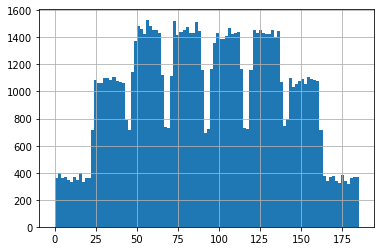

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0


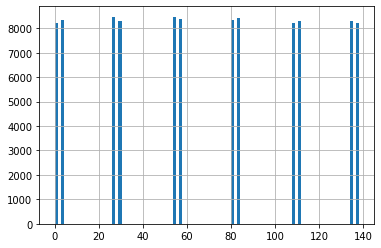

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Количество дубликатов: 0


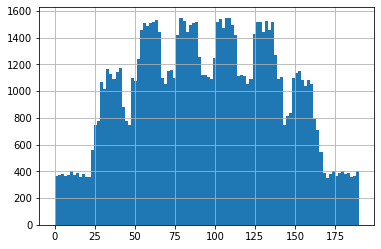

In [3]:
data0 = data_read('/datasets/geo_data_0.csv')
data1 = data_read('/datasets/geo_data_1.csv')
data2 = data_read('/datasets/geo_data_2.csv')

In [4]:
#Нужно избавиться от индексов
def ind(i):
    i.index = i['id']
    i.drop(['id'], axis = 1, inplace=True)
    return i

In [5]:
for i in (data0, data1, data2):
    ind(i)

In [7]:
data0

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...
DLsed,0.971957,0.370953,6.075346,110.744026
QKivN,1.392429,-0.382606,1.273912,122.346843
3rnvd,1.029585,0.018787,-1.348308,64.375443


## Обучение и проверка модели

In [8]:
feat = ['f0', 'f1', 'f2']
tar = ['product']

features0 = data0[feat] #вроде бы хорошо но реально ли еще и индекс перекинуть?
target0 = data0[tar]
features1 = data1[feat]
target1 = data1[tar]
features2 = data2[feat]
target2 = data2[tar]

In [9]:
def model(features, target):
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=0)

    lr = LinearRegression()
    lr.fit(features_train, target_train)
    predicted_valid = lr.predict(features_valid)

    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    print('Средний запас предсказанного сырья =', predicted_valid.mean())
    print('RMSE =', rmse)
    
    return target_valid, predicted_valid

In [10]:
target_valid0, predicted_valid0 = model(features0, target0)
target_valid1, predicted_valid1 = model(features1, target1)
target_valid2, predicted_valid2 = model(features2, target2)

Средний запас предсказанного сырья = 92.27144852242301
RMSE = 37.48100896950594
Средний запас предсказанного сырья = 69.15162398290752
RMSE = 0.8872573052219321
Средний запас предсказанного сырья = 94.70753129105672
RMSE = 40.31290686044374


In [11]:
display(pd.DataFrame(predicted_valid0).describe())
display(pd.DataFrame(predicted_valid1).describe())
display(pd.DataFrame(predicted_valid2).describe())

,0
count,25000.000000
mean,92.271449
std,23.272060
min,-2.475483
25%,76.249196
50%,92.280343
75%,108.364749
max,180.180276


,0
count,25000.000000
mean,69.151624
std,45.946473
min,-2.065137
25%,28.655850
50%,79.797299
75%,109.368702
max,139.983513


,0
count,25000.000000
mean,94.707531
std,19.948319
min,16.341652
25%,81.152293
50%,94.539196
75%,108.118157
max,166.272188


1-й регион прям очень хороший если медиана почти идентична среднему.

## Подготовка к расчёту прибыли

In [13]:
BAR = 45 * 10**4
BUDGET = 10**10
TOWERS = 200
COUNT = BUDGET / TOWERS / BAR
print(COUNT)

111.11111111111111


In [14]:
print(predicted_valid0.mean() - COUNT)
print(predicted_valid1.mean() - COUNT)
print(predicted_valid2.mean() - COUNT)

-18.8396625886881
-41.95948712820359
-16.40357982005439


По первому региону результаты неутешительные: в среднее нам не хватает 16% сырья для разработки. Как и примерно по третьему. В втором вообще страшно, но там была большая погрешность.

## Расчёт прибыли и рисков 

In [15]:
#особо понимания не прибавилось, потому просто попытаюсь для начала как я это вижу
predicted_valid0 = pd.Series(*predicted_valid0.reshape(1,-1))
target_valid0 = pd.Series(target_valid0['product']).reset_index(drop=True)

predicted_valid1 = pd.Series(*predicted_valid1.reshape(1,-1))
target_valid1 = pd.Series(target_valid1['product']).reset_index(drop=True)

predicted_valid2 = pd.Series(*predicted_valid2.reshape(1,-1))
target_valid2 = pd.Series(target_valid2['product']).reset_index(drop=True)

In [16]:
def profit(predict, target, name, show):
    top_predicts = predict.sort_values(ascending=False)[:TOWERS]
    top_targets = target[top_predicts.index]
    top_towers_mean = top_targets.mean()
    volume = sum(top_targets)
    profit = (volume * BAR - BUDGET) / 10**9

    if show == True:
        print('-- Регион {} --'.format(name))
        print('Средний объем {:.2f}'.format(top_towers_mean))
        print('Суммарный объем {:.2f}'.format(volume))
        print('Прибыль {:.2f} млрд'.format(profit))
    else:
        return profit

In [17]:
profit(predicted_valid0, target_valid0, '0', True)
profit(predicted_valid1, target_valid1, '1', True)
profit(predicted_valid2, target_valid2, '2', True)

-- Регион 0 --
Средний объем 148.48
Суммарный объем 29696.46
Прибыль 3.36 млрд
-- Регион 1 --
Средний объем 137.95
Суммарный объем 27589.08
Прибыль 2.42 млрд
-- Регион 2 --
Средний объем 140.27
Суммарный объем 28053.06
Прибыль 2.62 млрд


In [18]:
def region(probabilities, target):
    state = np.random.RandomState(0)
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=False, random_state=state)
        probs_subsample = probabilities[target_subsample.index] 
        values.append(profit(probs_subsample, target_subsample, '0', False))

    values = pd.Series(values)

    mean_values = values.mean()
    min_q = values.quantile(0.05/2)
    max_q = values.quantile(1 - 0.05/2)
    
    loss_rate = (values < 0).mean()
    
    print("Средняя выручка: {:.2f} млрд".format(mean_values))
    print('Доверительный интервал от {:.2f} млрд до {:.2f} млрд'.format(min_q, max_q))
    print('Риск убытков {:.2%}'.format(loss_rate))

In [19]:
region(predicted_valid0, target_valid0)
region(predicted_valid1, target_valid1)
region(predicted_valid2, target_valid2)

Средняя выручка: 0.43 млрд
Доверительный интервал от -0.10 млрд до 0.92 млрд
Риск убытков 4.80%
Средняя выручка: 0.48 млрд
Доверительный интервал от 0.09 млрд до 0.87 млрд
Риск убытков 1.20%
Средняя выручка: 0.38 млрд
Доверительный интервал от -0.15 млрд до 0.90 млрд
Риск убытков 7.80%


Для разработки нам подходит 1-й и 2-й регионы.

## Вывод

Имея среднюю прибыль почти пол миллиарда и шанс уйти в убыток 1.2% и 4.8% разработка выгодна лишь в 1-м и 2-м регионах соответственно. 3-й не подходит из-за большого шанса риска.